# Extract all features using Res18 

In [12]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def get_transform():
    return transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_pretrained_resnet18():
    model = resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model.to(device)

def extract_patches_and_features(image, bboxes, model, transform):
    patches = []
    features = []

    for bbox in bboxes:
        # extract patch
        x_min, y_min, x_max, y_max = bbox
        patch = image[y_min:y_max, x_min:x_max]
        patch = Image.fromarray(patch)
        
        # preprocessing patch
        transformed_patch = transform(patch).unsqueeze(0).to(device)
        
        # extract feature
        with torch.no_grad():
            feature = model(transformed_patch).squeeze().cpu().numpy()
        
        patches.append(transformed_patch)
        features.append(feature)
    
    return patches, features

def load_yolo_annotations(annotation_file, image):
    bboxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            # only extract x_center, y_center, width, height
            x_center, y_center, width, height = map(float, parts[1:5])
            # normalized axis to absolute pixel axis
            img_width, img_height = image.shape[1], image.shape[0]
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_width)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_width)
            bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes

def unnormalize(img, mean, std):
    img = img * std[:, None, None] + mean[:, None, None]
    return img



In [13]:
transform = get_transform()
model = get_pretrained_resnet18()

image_dir = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/5_mixed/Det-dominik_v1-sf_v1.v2i.yolov8/train/images'
annotation_dir = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/5_mixed/Det-dominik_v1-sf_v1.v2i.yolov8/train/labels'
output_dir = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search'

all_features = []
all_bboxes = []
all_image_names = []
all_patches = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        # load image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        
        # BGR -> RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # load annotations in YOLO format
        annotation_file = os.path.join(annotation_dir, os.path.splitext(image_file)[0] + '.txt')
        bboxes = load_yolo_annotations(annotation_file, image)

        # extract patches and features
        patches, features = extract_patches_and_features(image, bboxes, model, transform)
        
        # save patches
        all_patches.extend(patches)
        
        # save features and related information
        all_features.extend(features)
        all_bboxes.extend(bboxes)
        all_image_names.extend([image_file] * len(bboxes))

# randomly show 10 patches
if all_patches:
    num_patches_to_show = min(10, len(all_patches))
    random_indices = np.random.choice(len(all_patches), num_patches_to_show, replace=False)
    for random_index in random_indices:
        random_patch = all_patches[random_index].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        random_patch = unnormalize(random_patch, mean, std)
        
        # limit the pixel in  [0, 1]
        random_patch = np.clip(random_patch, 0, 1)
        
        plt.imshow(np.transpose(random_patch, (1, 2, 0)))
        plt.title(f"Random Patch from Dataset")
        plt.show()

# save npz
all_features_np = np.array(all_features).astype('float32')
all_bboxes_np = np.array(all_bboxes)
all_image_names_np = np.array(all_image_names)
np.savez(output_dir + '/training_data.npz', features=all_features_np, bboxes=all_bboxes_np, image_names=all_image_names_np)


KeyboardInterrupt: 

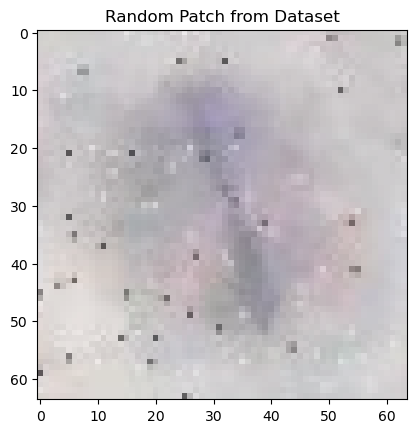

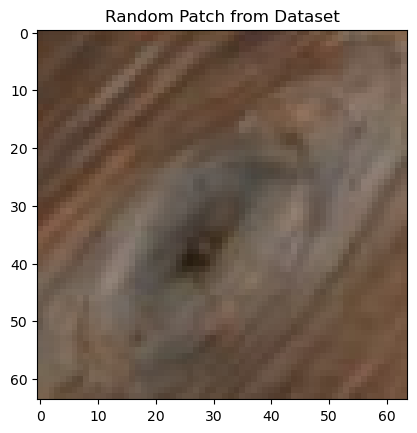

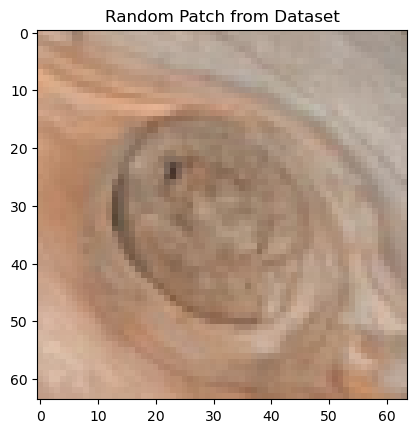

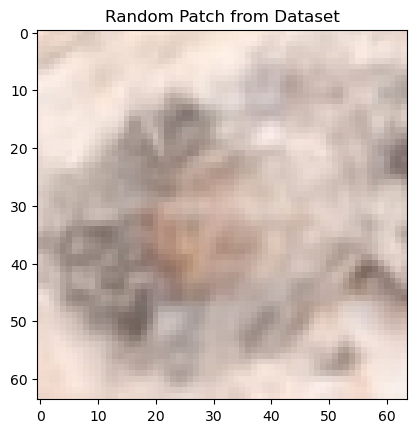

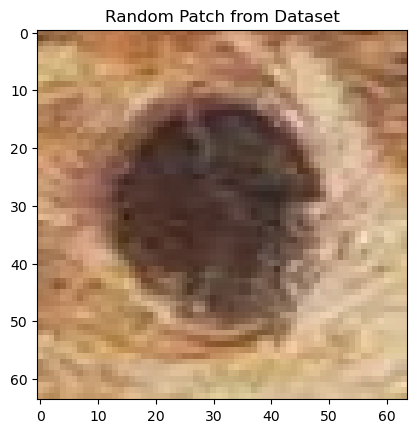

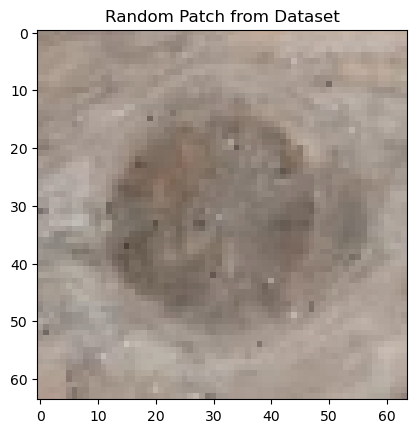

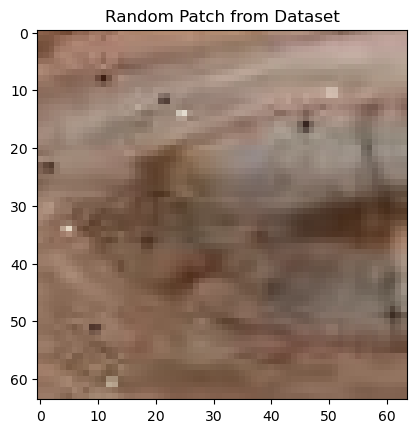

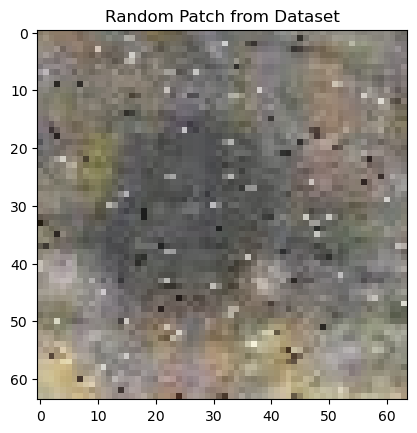

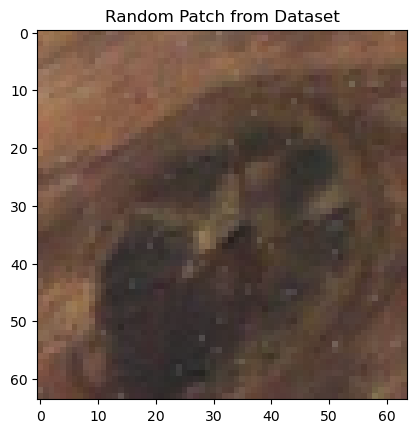

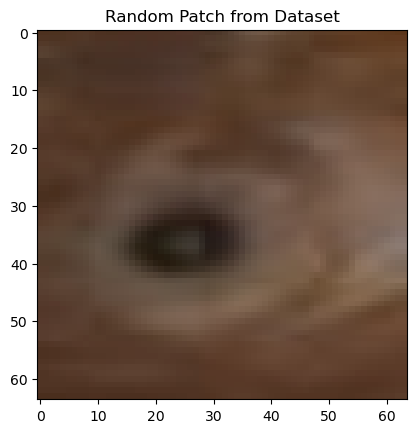

In [ ]:
# randomly show 10 patches
if all_patches:
    num_patches_to_show = min(10, len(all_patches))
    random_indices = np.random.choice(len(all_patches), num_patches_to_show, replace=False)
    for random_index in random_indices:
        random_patch = all_patches[random_index].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        random_patch = unnormalize(random_patch, mean, std)
        
        # limit the pixel in  [0, 1]
        random_patch = np.clip(random_patch, 0, 1)
        
        plt.imshow(np.transpose(random_patch, (1, 2, 0)))
        plt.title(f"Random Patch from Dataset")
        plt.show()


# kNN on target image with results

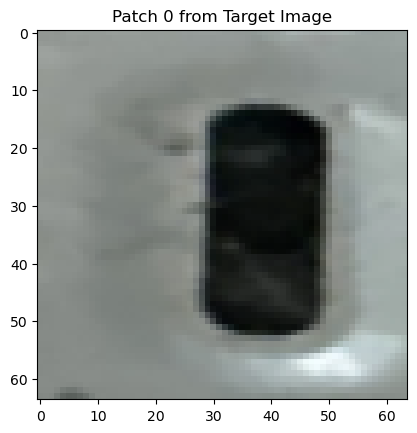

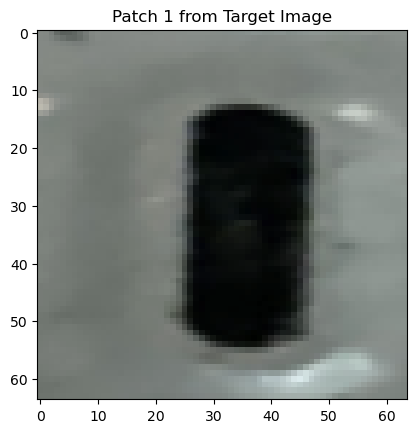

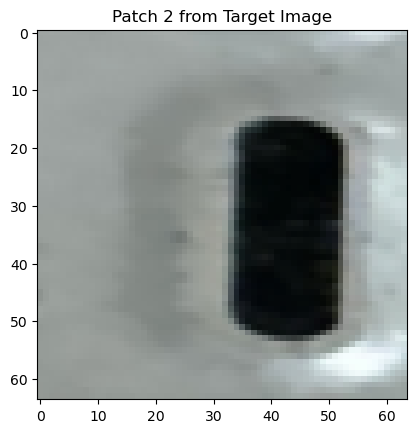

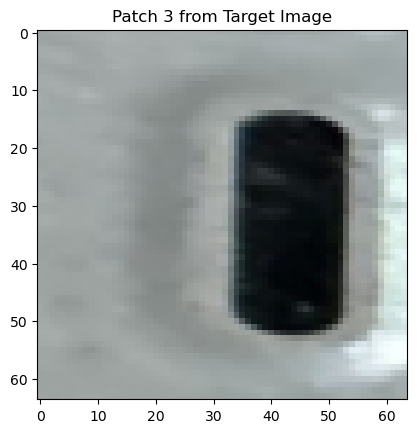

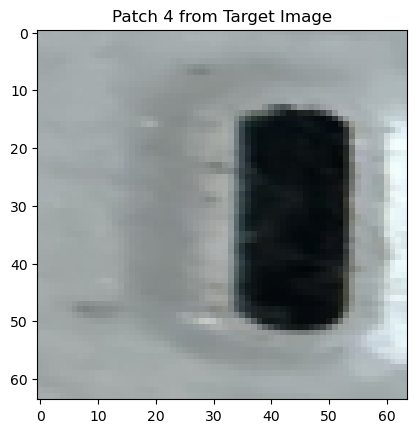

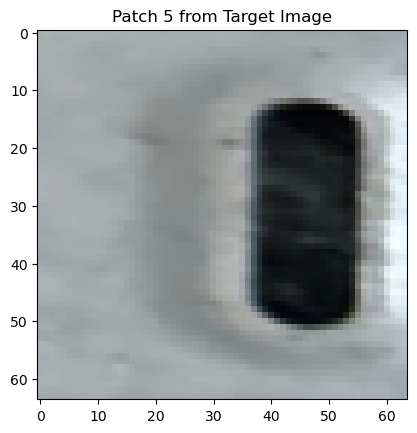

tf:  [array([3.3806517e+00, 3.3736140e-01, 5.6637301e+00, 3.5101042e+00,
       0.0000000e+00, 2.6099384e-01, 5.0726432e-01, 0.0000000e+00,
       3.2502565e+00, 2.8116281e+00, 0.0000000e+00, 2.3613045e+00,
       7.6150548e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5741824e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.9066261e-01, 0.0000000e+00, 1.0542397e+00, 1.1049869e+00,
       5.4141054e+00, 1.3491417e-01, 0.0000000e+00, 9.7933605e-02,
       7.5979269e-01, 1.4396191e+00, 5.5362291e+00, 3.3929040e+00,
       0.0000000e+00, 0.0000000e+00, 5.4118242e+00, 2.0629823e-02,
       5.9301060e-01, 3.6920229e-01, 3.7532374e-02, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.5138476e-01, 3.4962937e-01, 3.7084341e-02, 4.2925102e-01,
       0.0000000e+00, 0.0000000e+00, 3.4431958e-01, 7.1738453e+00,
       0.0000000e+00, 4.9851255e+00, 4.4390578e+00, 8.1880045e-01,
       2.7066579e-01, 5.6151891e-01, 0.0000000e+00, 0.00

In [14]:
import json
import cv2
import torch

def read_json(json_file):
    with open(json_file, 'r') as file:
        return json.load(file)


transform = get_transform()
model = get_pretrained_resnet18()

# #! image with 6 knots
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M1_0244.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M1_0244.json'

# #! image with overlapping knot
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M5_0064.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M5_0064.json'

#! image with metal
target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M2_0082.jpeg'
target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M2_0082.json'

# #! image without knot
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M6_0118.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M6_0118.json'

knn_bank = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/kNN_knot.npz'

all_data = np.load(knn_bank)
all_features = all_data['features']
all_features_tensor = torch.tensor(all_features, dtype=torch.float32)


target_features = []
target_bboxes = []
target_ori_image = []
target_patches = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# read image and json
image = cv2.imread(target_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

json_data = read_json(target_json)

# extract bboxes
for box in json_data['boxes']:
    coordinates = (box['x1'], box['y1'], box['x2'], box['y2'])
    target_bboxes.append(coordinates)

# extract patches and features
patches, features = extract_patches_and_features(image, target_bboxes, model, transform)
target_patches.extend(patches)
target_features.extend(features)

if target_patches:
    num_patches_to_show = min(10, len(target_patches))
    for index in range(num_patches_to_show):
        patch = target_patches[index].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        patch = unnormalize(patch, mean, std)
        
        # limit the pixel values to [0, 1]
        patch = np.clip(patch, 0, 1)
        
        plt.imshow(np.transpose(patch, (1, 2, 0)))
        plt.title(f"Patch {index} from Target Image")
        plt.show()


print("tf: ", target_features)
print("tb: ", target_bboxes)
print("tp: ", target_patches)

In [ ]:
knn_bank = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/kNN_knot.npz'

import numpy as np

data = np.load(knn_bank)

print("Keys in the npz file:", list(data.keys()))


# use saved features to apply knn search within all_feature

## use Euclidean Distance

In [15]:
import numpy as np
import torch

class ed_kNN:
    def __init__(self, k):
        self.k = k
        self.X_train = None

    def fit(self, X_train):
        self.X_train = X_train

    def predict(self, X_test):
        distances = torch.cdist(X_test, self.X_train, p=2)
        knn_indices = distances.topk(self.k, dim=1, largest=False).indices
        return knn_indices
    
#! distance threshold
distance_threshold = 45

filtered_results = []

for index, target_feature in enumerate(target_features):
    target_feature = torch.tensor(target_feature, dtype=torch.float32).unsqueeze(0)
    
    # all_features_tensor = torch.nn.functional.normalize(all_features_tensor, p=2, dim=1)
    # target_feature = torch.nn.functional.normalize(target_feature, p=2, dim=1)

    # fit kNN model
    knn = ed_kNN(k=10)
    knn.fit(all_features_tensor)

    # predict neighbors
    predicted_neighbors = knn.predict(target_feature)
    
    # calculate distances
    distances = torch.cdist(target_feature, all_features_tensor[predicted_neighbors], p=2).squeeze()
    
    print(f"Target Feature Index: {index}, Min Distance: {distances.min().item()}")

    
    if distances.min().item() < distance_threshold:
        filtered_results.append({
            "target_index": index,
            "target_bbox": target_bboxes[index],
            "target_patch": target_patches[index],
            "predicted_neighbors": predicted_neighbors.cpu().numpy().tolist(),
            "min_distance": distances.min().item()
        })

for result in filtered_results:
    print(f"Target Feature Index: {result['target_index']}")
    print(f"Bounding Box: {result['target_bbox']}")
    print(f"Predicted Neighbors' Indices: {result['predicted_neighbors']}")
    print(f"Minimum Distance: {result['min_distance']}")
    
if filtered_results:
    num_patches_to_show = min(10, len(filtered_results))
    for i in range(num_patches_to_show):
        result = filtered_results[i]
        patch = result['target_patch'].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        patch = unnormalize(patch, mean, std)
        
        # limit the pixel values to [0, 1]
        patch = np.clip(patch, 0, 1)
        
        plt.imshow(np.transpose(patch, (1, 2, 0)))
        plt.title(f"Filtered Patch {result['target_index']} with Min Distance: {result['min_distance']}")
        plt.show()



Target Feature Index: 0, Min Distance: 46.32551574707031
Target Feature Index: 1, Min Distance: 46.96440887451172
Target Feature Index: 2, Min Distance: 46.93000030517578
Target Feature Index: 3, Min Distance: 49.26069259643555
Target Feature Index: 4, Min Distance: 51.21551513671875
Target Feature Index: 5, Min Distance: 48.785057067871094


## use cosine similarity

In [16]:
import torch

class cos_kNN:
    def __init__(self, k):
        self.k = k
        self.X_train = None

    def fit(self, X_train):
        self.X_train = X_train

    def predict(self, X_test):
        # Normalize both X_train and X_test -> unit vectors
        X_train_norm = torch.nn.functional.normalize(self.X_train, p=2, dim=1)
        X_test_norm = torch.nn.functional.normalize(X_test, p=2, dim=1)

        cosine_similarity = torch.matmul(X_test_norm, X_train_norm.T)
        cosine_distance = 1 - cosine_similarity

        knn_indices = cosine_distance.topk(self.k, dim=1, largest=False).indices
        return knn_indices

distance_threshold = 0.3

filtered_results = []

for index, target_feature in enumerate(target_features):
    target_feature = torch.tensor(target_feature, dtype=torch.float32).unsqueeze(0)
    
    # fit kNN model
    knn = cos_kNN(k=10)
    knn.fit(all_features_tensor)

    # predict neighbors
    predicted_neighbors = knn.predict(target_feature)
    
    # calculate cosine distance for the k nearest neighbors
    X_train_norm = torch.nn.functional.normalize(all_features_tensor[predicted_neighbors].squeeze(0), p=2, dim=1)
    X_test_norm = torch.nn.functional.normalize(target_feature, p=2, dim=1)

    # calculate cosine similarity using torch.nn.functional.cosine_similarity
    cosine_similarity = torch.nn.functional.cosine_similarity(X_test_norm, X_train_norm)
    cosine_distance = 1 - cosine_similarity

    print(f"Target Feature Index: {index}, Min Cosine Distance: {cosine_distance.min().item()}")

    if cosine_distance.min().item() < distance_threshold:
        filtered_results.append({
            "target_index": index,
            "target_bbox": target_bboxes[index],
            "target_patch": target_patches[index],
            "predicted_neighbors": predicted_neighbors.cpu().numpy().tolist(),
            "min_distance": cosine_distance.min().item()
        })

for result in filtered_results:
    print(f"Target Feature Index: {result['target_index']}")
    print(f"Bounding Box: {result['target_bbox']}")
    print(f"Predicted Neighbors' Indices: {result['predicted_neighbors']}")
    print(f"Minimum Cosine Distance: {result['min_distance']}")
    
if filtered_results:
    num_patches_to_show = min(10, len(filtered_results))
    for i in range(num_patches_to_show):
        result = filtered_results[i]
        patch = result['target_patch'].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        patch = unnormalize(patch, mean, std)
        
        # limit the pixel values to [0, 1]
        patch = np.clip(patch, 0, 1)
        
        plt.imshow(np.transpose(patch, (1, 2, 0)))
        plt.title(f"Filtered Patch {result['target_index']} with Min Cosine Distance: {result['min_distance']:.4f}")
        plt.show()



Target Feature Index: 0, Min Cosine Distance: 0.31734776496887207
Target Feature Index: 1, Min Cosine Distance: 0.30587100982666016
Target Feature Index: 2, Min Cosine Distance: 0.3068404197692871
Target Feature Index: 3, Min Cosine Distance: 0.340423583984375
Target Feature Index: 4, Min Cosine Distance: 0.36352163553237915
Target Feature Index: 5, Min Cosine Distance: 0.31288087368011475


# final test

In [4]:
import json
import cv2
import torch
import numpy as np
from torchvision.models import resnet18
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import os

# Define transformation for the images
def get_transform():
    return transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Load a pre-trained ResNet-18 model
def get_pretrained_resnet18():
    model = resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])  # Remove the last fully connected layer
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model.to(device)

# Extract patches and features from the image based on bounding boxes
def extract_patches_and_features(image, bboxes, model, transform, device):
    patches = []
    features = []

    for bbox in bboxes:
        # Extract patch
        x_min, y_min, x_max, y_max = bbox
        patch = image[y_min:y_max, x_min:x_max]
        patch = Image.fromarray(patch)
        
        # Preprocess patch
        transformed_patch = transform(patch).unsqueeze(0).to(device)
        
        # Extract feature using the model
        with torch.no_grad():
            feature = model(transformed_patch).squeeze().cpu().numpy()
        
        patches.append(transformed_patch)
        features.append(feature)
    
    return patches, features

# Load YOLO annotations (bounding boxes)
def load_yolo_annotations(annotation_file, image):
    bboxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            x_center, y_center, width, height = map(float, parts[1:5])
            img_width, img_height = image.shape[1], image.shape[0]
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_width)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_width)
            bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes

# Read JSON file
def read_json(json_file):
    with open(json_file, 'r') as file:
        return json.load(file)

def save_image_with_bboxes(image, bboxes, scores, save_path, font_size=20, font_color=(255, 0, 0), font_thickness=2):
    """
    Save the image with bounding boxes and their corresponding confidence scores using OpenCV.

    Args:
    - image: The image on which to draw (in NumPy array format).
    - bboxes: A list of bounding boxes, each as (x1, y1, x2, y2).
    - scores: A list of confidence scores corresponding to each bounding box.
    - save_path: The path where the image with bounding boxes will be saved.
    - font_size: The size of the font for displaying confidence scores.
    - font_color: The color of the font for displaying confidence scores (BGR tuple).
    - font_thickness: The thickness of the font.
    """
    # Convert the PIL image to an OpenCV image (NumPy array)
    image = np.array(image)

    for bbox, score in zip(bboxes, scores):
        # Draw the rectangle for the bounding box
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(255, 0, 0), thickness=3)

        # Prepare the text (confidence score)
        text = f"{score:.2f}"
        
        # Set text position (top-left corner of the bounding box)
        text_position = (bbox[0], bbox[1] - 10 if bbox[1] - 10 > 10 else bbox[1] + 10)
        
        # Put the text on the image
        cv2.putText(image, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)

    # Save the image using OpenCV
    cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert RGB back to BGR before saving
        
def save_json_with_bboxes(json_data, boxes_tuples, scores_list, save_path, image_name):
    """
    Save the processed JSON file with updated image name and bounding boxes.

    Args:
    - json_data: The original JSON data.
    - boxes_tuples: A list of processed bounding boxes, each containing (x1, y1, x2, y2).
    - scores_list: A list of confidence scores corresponding to the bounding boxes.
    - save_path: The path where the updated JSON file will be saved.
    - image_name: The name of the processed image to be added in the JSON data.
    """
    # Add the processed image name to the JSON data
    json_data["image"] = image_name
    
    # Clear the existing bounding box data in the JSON and add the updated boxes and scores
    json_data["boxes"] = []
    
    # Iterate over each bounding box and its corresponding confidence score
    for box, score in zip(boxes_tuples, scores_list):
        # Append the bounding box and its confidence score to the JSON data
        json_data["boxes"].append({
            "confidence": score,
            "x1": box[0],
            "y1": box[1],
            "x2": box[2],
            "y2": box[3]
        })
    
    # Save the updated JSON data to the specified file path
    with open(save_path, 'w') as file:
        json.dump(json_data, file, indent=4)


# KNN class for cosine similarity-based search
class cos_kNN:
    def __init__(self, k):
        self.k = k
        self.X_train = None

    def fit(self, X_train):
        self.X_train = X_train

    def predict(self, X_test):
        # Normalize both X_train and X_test -> unit vectors
        X_train_norm = torch.nn.functional.normalize(self.X_train, p=2, dim=1)
        X_test_norm = torch.nn.functional.normalize(X_test, p=2, dim=1)

        # Cosine similarity and distances
        cosine_similarity = torch.matmul(X_test_norm, X_train_norm.T)
        cosine_distance = 1 - cosine_similarity

        # Find k nearest neighbors based on cosine distance
        knn_indices = cosine_distance.topk(self.k, dim=1, largest=False).indices
        return knn_indices

# Main function to process images, extract features, and perform kNN search
def process_knn(image_folder, target_folder, output_folder, knn_bank, distance_threshold=0.3):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = get_transform()
    model = get_pretrained_resnet18()

    # Load the kNN feature bank
    all_data = np.load(knn_bank)
    all_features = all_data['features']
    all_features_tensor = torch.tensor(all_features, dtype=torch.float32)

    # Traverse target folder to find all JSON files
    for target_file in os.listdir(target_folder):
        if target_file.endswith('.json'):
            json_path = os.path.join(target_folder, target_file)
            json_data = read_json(json_path)

            # Get image name from JSON and load image
            image_name = json_data['image']
            img_path = os.path.join(image_folder, image_name)

            if not os.path.exists(img_path):
                print(f"Image {image_name} not found in {image_folder}, skipping...")
                continue

            # Read image and convert to RGB
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            target_bboxes = []
            target_features = []
            target_scores = []
            filtered_results = []

            # Extract bounding boxes and confidence scores from JSON
            for box in json_data['boxes']:
                coordinates = [box['x1'], box['y1'], box['x2'], box['y2']]
                target_bboxes.append(coordinates)
                target_scores.append(box['confidence'])


            # Extract patches and features
            patches, features = extract_patches_and_features(image, target_bboxes, model, transform, device)
            target_features.extend(features)

            # KNN search for each target feature
            for index, target_feature in enumerate(target_features):
                target_feature_tensor = torch.tensor(target_feature, dtype=torch.float32).unsqueeze(0)

                # Fit kNN model
                knn = cos_kNN(k=10)
                knn.fit(all_features_tensor)

                # Predict neighbors
                predicted_neighbors = knn.predict(target_feature_tensor)

                # Calculate cosine similarity for k nearest neighbors
                X_train_norm = torch.nn.functional.normalize(all_features_tensor[predicted_neighbors].squeeze(0), p=2, dim=1)
                X_test_norm = torch.nn.functional.normalize(target_feature_tensor, p=2, dim=1)
                cosine_similarity = torch.nn.functional.cosine_similarity(X_test_norm, X_train_norm)
                cosine_distance = 1 - cosine_similarity

                # Filter results based on distance threshold
                if cosine_distance.min().item() < distance_threshold:
                    filtered_results.append({
                        "target_index": index,
                        "target_bbox": target_bboxes[index],
                        "predicted_neighbors": predicted_neighbors.cpu().numpy().tolist(),
                        "min_distance": cosine_distance.min().item()
                    })

            # Save the filtered results with the knn_red_nms_ prefix
            output_json_name = f"knn_red_nms_{os.path.splitext(image_name)[0]}.json"
            output_json_path = os.path.join(output_folder, output_json_name)

            if filtered_results:
                save_json_with_bboxes(json_data, target_bboxes, target_scores, output_json_path, image_name)

                # Save the image with bounding boxes
                output_img_name = f"knn_red_nms_{image_name}"
                output_img_path = os.path.join(output_folder, output_img_name)
                save_image_with_bboxes(image, target_bboxes, target_scores, output_img_path, font_size=1, font_color=(255, 0, 0), font_thickness=4)
            
            print(f"Processed KNN results saved to: {output_json_path}")

# Paths for input, output and kNN bank
image_folder = "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans"
target_folder = "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans/3_ostu"
output_folder = "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans/4_knn"
knn_bank = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/kNN_knot.npz'

# Run the process
process_knn(image_folder, target_folder, output_folder, knn_bank)

Processed KNN results saved to: /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans/4_knn/knn_red_nms_warped_M2_0120.json
Processed KNN results saved to: /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans/4_knn/knn_red_nms_warped_M1_0175.json
Processed KNN results saved to: /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans/4_knn/knn_red_nms_warped_M4_0029.json
Processed KNN results saved to: /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans/4_knn/knn_red_nms_warped_M1_0030.json
Processed KNN results saved to: /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_general_workflow/5_trans/4_knn/knn_red_nms_warped_M5_0035.json
Processed KNN results saved to: /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/4_Maria_0710/Test_g